# 가중치 시각화

2절에서 만든 모델이 어떤 가중치를 학습했는지 확인하기 위해 'best-cnn-model.h5' 체크포인트 파일을 읽어보자.

In [19]:
from tensorflow import keras

model = keras.models.load_model('/content/drive/MyDrive/공부/혼공머신/best-cnn-model.h5')

케라스 모델에 추가한 층은 layers 속성에 저장되어 있다.

In [20]:
model.layers

레이어의 가중치와 절편은 그 층의 weights 속성에 저장되어 있다.

layers 속성의 첫 번째 원소(1번 Conv)를 선택해 weights의 첫 번째 원소(가중치)와 두 번째 원소(절편)의 크기를 출력해보자.

In [21]:
conv = model.layers[0]
print(conv.weights[0].shape, conv.weights[1].shape)

(3, 3, 1, 32) (32,)


커널 크기가 3x3x1 이고, 커널 개수가 32개이므로 가중치의 크기는 (3, 3, 1, 32)가 되었다.

절편의 크기는 커널의 개수와 같으므로 (32, )가 되었다.

weights 속성은 텐서플로의 다차원 배열인 Tensor 클래스의 객체이다.
- 다루기 쉽도록 numpy() 함수를 사용해 넘파이 배열로 변환하자.

그 다음 가중치 배열의 평균과 표준편차를 넘파이 mean() 함수와 std() 함수로 계산해보자.

In [22]:
conv_weights = conv.weights[0].numpy()

print(conv_weights.mean(), conv_weights.std())

-0.026237741 0.2501305


나중에 이 값을 훈련 전 가중치와 비교해보자.

이 가중치가 어떤 분포를 가졌는지 직관적 이해를 위해 히스토그램을 그려보자

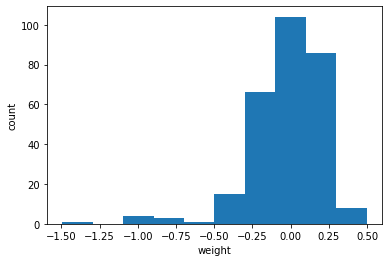

In [23]:
import matplotlib.pyplot as plt

plt.hist(conv_weights.reshape(-1, 1)) # hist() 를 위해 2차원 배열 형태로 전달
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

0을 중심으로 퍼져있는 분포를 띠고 있다. 이 가중치가 무언가 의미를 학습한 것일까?

이것도 나중에 훈련 전 가중치와 비교해보자.

이번에는 32개의 커널을 16개씩 두 줄에 출력해보자.
- conv_weights: (3, 3, 1, )의 0번 커널부터 31번 커널까지 순회
- vmin, vmax
    - imshow() 함수는 배열에 있는 최소값과 최대값을 사용해 픽셀의 강도를 표현한다.
    - 배열 내 최대값은 항상 밝은 노란 색으로 그린다.
    - 그러므로 서로 다른 배열 간의 비교에는 수치에 따른 색에 대한 기준이 필요하다.
    - vmin, vmax는 컬러맵으로 표현할 범위를 지정한다.

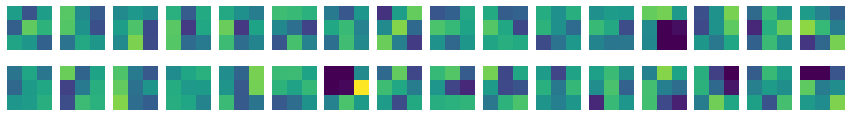

In [24]:
fig, axs = plt.subplots(2, 16, figsize=(15, 2))
for i in range(2):
    for j in range(16):
        axs[i, j].imshow(conv_weights[:, :, 0, i*16 + j], vmin=-0.5, vmax=0.5)
        axs[i, j].axis('off')
plt.show()

밝은 부분은 가중치가 높다는 것이므로, 이미지에서 그 위치에 있는 선(점)을 만나면 크게 활성화 될 것이다.

이번에는 훈련하지 않은 빈 CNN을 만들어보고, 이 Conv 층의 가중치가 위에서 훈련된 가중치와 어떤 차이가 있는지 비교해보자.

In [25]:
no_training_model = keras.Sequential()
no_training_model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(28, 28, 1)))

In [26]:
no_training_conv = no_training_model.layers[0]
print(no_training_conv.weights[0].shape)

(3, 3, 1, 32)


가중치의 형태 자체는 학습된 conv 층과 같다.

다음으로 평균과 표준편차를 구해보고, 히스토그램으로 나타내보자

-0.008033061 0.08388509


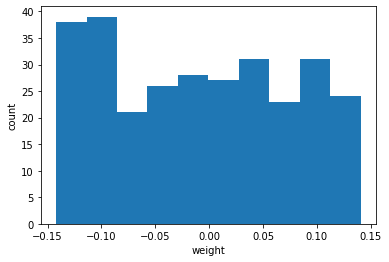

In [27]:
no_training_weights = no_training_conv.weights[0].numpy()

print(no_training_weights.mean(), no_training_weights.std())

plt.hist(no_training_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

표준편차가 매우 작아졌고, -0.15 ~ +0.15 범위에서 비교적 고르게 분포되어 있다.

이제 그림으로 표현해보자.

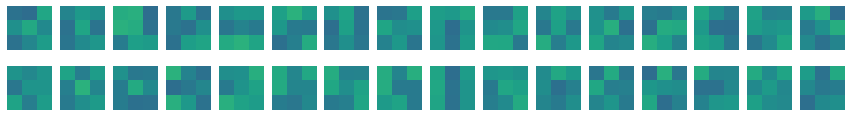

In [28]:
fig, axs = plt.subplots(2, 16, figsize=(15, 2))
for i in range(2):
    for j in range(16):
        axs[i, j].imshow(no_training_weights[:, :, 0, i*16 + j], vmin=-0.5, vmax=0.5)
        axs[i, j].axis('off')
plt.show()

전체적으로 가중치가 밋밋하게 초기화되었다.

합성곱 신경망의 학습을 시각화하는 두 번째 방법은, conv를 거친 특성 맵을 그려 보는 것이다. 이를 통해 CNN이 입력 이미지를 어떻게 바라보는지 엿볼 수 있다.

그 전에 케라스의 함수형 API에 대해 잠시 알아보자.

# 함수형 API

딥러닝에는 좀 더 복잡한 모델이 많이 있다.
- 예: 입력이 2개 이상일 수도 있고, 출력이 2개 이상일 수도 있다.

이런 경우는 Sequential 클래스를 사용하기 어렵고, 대신 함수형 API를 사용한다.

함수형 API는 케라스의 Model 클래스를 사용하여 모델을 만든다.

간단한 예를 들기 위해, Dense 층 2개로 이루어진 FC 신경망을 함수형 API로 구현해보자.

먼저 2개의 Dense 층 객체를 만든다.

In [14]:
# dense1 = keras.layers.Dense(100, activation='sigmoid')
# dense2 = keras.layers.Dense(10, activation='softmax')

위 코드는 7장에서의 코드와 거의 동일하여, 이 객체를 Sequential 클래스의 add()로 넘길 수도 있다. (input_shape를 지정해야겠지만)

하지만 다음과 같이 함수처럼 호출할 수도 있다.
- 파이썬의 모든 객체는 호출 가능하다.
- 케라스의 Layer는 객체를 함수처럼 호출했을 때 적절히 동작할 수 있도록 미리 준비되어 있다.

In [15]:
# hidden = dense1(inputs) # 입력값 inputs를 dense1에 통과시켜, 출력값 hidden 생성
# outputs = dense2(hidden) # 입력값 hidden을 dense2에 통과시켜, 출력값 outputs 생성

그 다음, inputs와 outputs를 Model 클래스로 연결해주면 된다.

In [16]:
# model = keras.Model(inputs, outputs)

근데 inputs는 어디서 나오는 걸까?
- 앞선 08-2에서 keras.utils.plot_model() 함수를 통해 층의 형태를 살펴보면, 맨 위에 InputLayer 클래스가 있는 것을 볼 수 있다.
- Sequential 클래스는 이 클래스를 자동으로 추가하고 호출해 주지만,
- Model 클래스에서는 수동으로 만들어서 호출해야 한다.
- --> inputs == InputLayer 클래스의 출력값

다행히 케라스는 InputLayer 클래스 객체를 쉽게 다룰 수 있도록 Input() 함수를 별도로 제공한다.
- 입력의 크기를 지정하는 shape 매개변수와 함께 이 함수를 호출하면 InputLayer 객체를 만드러 출력을 반환해준다.

In [12]:
# inputs = keras.Input(shape=(784, ))

In [17]:
# 코드 정리
dense1 = keras.layers.Dense(100, activation='sigmoid')
dense2 = keras.layers.Dense(10, activation='softmax')

inputs = keras.Input(shape=(784, ))
hidden = dense1(inputs) # 입력값 inputs를 dense1에 통과시켜, 출력값 hidden 생성
outputs = dense2(hidden) # 입력값 hidden을 dense2에 통과시켜, 출력값 outputs 생성

model = keras.Model(inputs, outputs)

그런데 특성 맵 시각화를 하는데 함수형 API가 왜 필요한 것일까?
- Sequential로 만든 모델로는 중간 층까지에 대한 예측을 출력할 수 없기 때문에
- 함수형 API를 별개의 층과 층을 잇는 새로운 모델을 만드는 데 이용할 수 있다.

2절에서 정의한 model 객체의 층을 순서대로 나타내면 다음과 같다.
- InputLater
- Conv2D_1 --> 활성화 출력
- Maxpooling2D_1
- Conv2D_2
- Maxpooling2D_2
- Flatten --> Dense_1 --> Dropout --> Dense_2

model 객체의 입력과 Conv2D의 출력을 알 수 있다면, 이 둘을 연결하여 새로운 모델을 얻을 수 있지 않을까?
- model 객체의 입력은 model.input으로 얻을 수 있다.
- Conv2D_1 의 출력은 Conv2D_1 객체의 output 속성에서 얻을 수 있다.
    - model.layers[0].output

In [30]:
print(model.input)
print(model.layers[0].output)

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='conv2d_input'), name='conv2d_input', description="created by layer 'conv2d_input'")
KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 32), dtype=tf.float32, name=None), name='conv2d/Relu:0', description="created by layer 'conv2d'")


이제 위 두 객체를 연결하는 새로운 모델을 만들 수 있다.

In [31]:
conv_acti = keras.Model(model.input, model.layers[0].output)

model.predict()를 호출하면 최종 출력층의 확률을 반환한다.

그러나, conv_acti.predict()를 호출하면 Conv2D_1의 출력을 반환한다.

# 특성 맵 시각화

먼저 패션 MNIST 데이터셋을 읽은 후 훈련 세트에 있는 첫 번째 샘플을 그려 보자.

4431872/4422102 [==============================] - 0s 0us/step


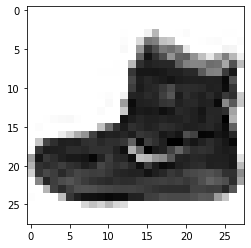

In [32]:
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
plt.imshow(train_input[0], cmap='gray_r')
plt.show()

이 샘플을 conv_acti 모델에 주입하여 Conv2D_1 층이 만드는 특성 맵을 출력해보자.
- predict() 함수는 입력의 첫 차원이 배치 차원일 것으로 기대하므로, 슬라이싱으로 샘플을 선택하자.
- 그 다음 (784, ) 크기를 (28, 28, 1) 크기로 변경하고 정규화하자.

In [33]:
inputs = train_input[0:1].reshape(-1, 28, 28, 1) / 255.0
feature_maps = conv_acti.predict(inputs)

conv_acti.predict() 함수가 출력한 feature_maps의 크기를 확인해보자.

In [34]:
print(feature_maps.shape)

(1, 28, 28, 32)


same padding과 32개의 필터를 사용한 Conv 층의 출력이므로 (28, 28, 32) 크기를 갖는다. (배치 차원 제외)

이제 앞에서와 같이 이 특성 맵을 그려보자.

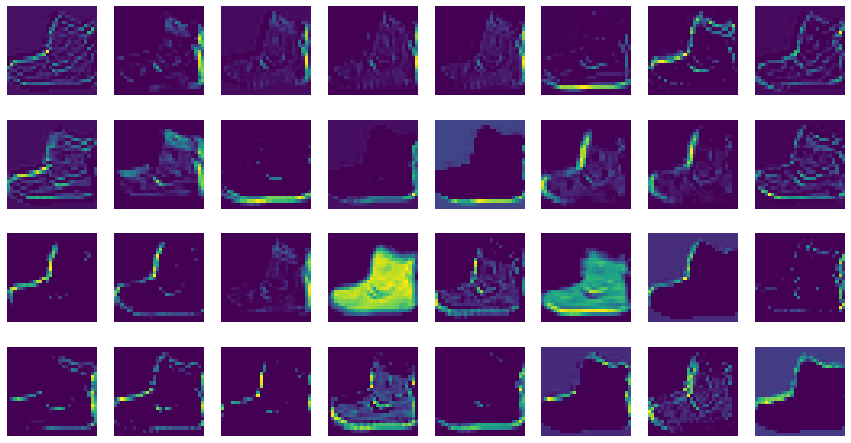

In [35]:
fig, axs = plt.subplots(4, 8, figsize=(15, 8))
for i in range(4):
    for j in range(8):
        axs[i, j].imshow(feature_maps[0, :, :, i*8+j])
        axs[i, j].axis('off')
plt.show()

이 특성 맵은 32개의 필터로 인해 입력 이미지에서 강하게 활성화된 부분을 보여준다.
- 예를 들면 8번째 필터는 우상향 대각선을 감지하는데, 위 그림에서 8째 특성 맵을 보면, 우상향 대각선이 활성화 된 것을 볼 수 있다.

두 번째 conv 층이 만든 특성 맵도 같은 방식으로 확인할 수 있다.
- model 객체의 입력과 model.layers[2]의 출력을 연결

In [36]:
conv2_acti = keras.Model(model.input, model.layers[2].output)

그 다음 첫 샘플을 위 모델의 predict() 함수로 전달하자.

In [37]:
inputs = train_input[0:1].reshape(-1, 28, 28, 1) / 255.0
feature_maps = conv2_acti.predict(inputs)

print(feature_maps.shape)

(1, 14, 14, 64)


풀링을 하나 거치고, 필터가 64개 있었으므로 두 번째 특성 맵은 위와 같은 형태를 띠는 것을 알 수 있다.

이 64개의 특성 맵도 이미지로 그려보자

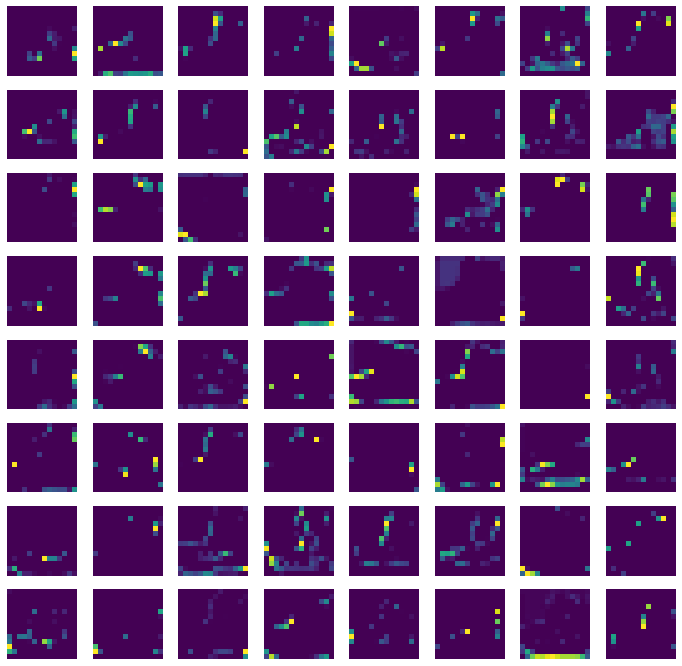

In [39]:
fig, axs = plt.subplots(8, 8, figsize=(12, 12))
for i in range(8):
    for j in range(8):
        axs[i, j].imshow(feature_maps[0, :, :, i*8+j])
        axs[i, j].axis('off')
plt.show()

첫 번째 특성 맵에 비해서 시각적으로 어떤 부위가 중요하게 감지되는지 알기 힘들다.
- 이는, Conv2D_2는 Conv2D_1의 특성 맵에 또 다른 필터가 곱해져서 출력된 값이기 때문이다.
- 이러한 현상은 합성곱 층을 쌓으면 쌓을수록 심해진다.

--> CNN의 앞부분의 Conv 층은 이미지의 시각적인 정보를 감지하고,

뒤쪽에 있는 Conv 일수록 앞쪽의 시각적 정보를 바탕으로 추상적 정보를 학습한다고 볼 수 있다.